# 03 — Evaluación + Inferencia (FIX)

Este notebook:
- Carga `test_split.csv` (mismo test set siempre)
- Carga un checkpoint
- Calcula métricas y hace inferencia básica


In [22]:
import os, json
import numpy as np
import pandas as pd
import torch

OUT_DIR = r"C:\Users\User\Downloads\COVID_HYBRID_experiment2"  # <-- ajusta si tu ruta es otra
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

with open(os.path.join(OUT_DIR, "config_runtime.json"), "r", encoding="utf-8") as f:
    cfg = json.load(f)

IMG_SIZE     = int(cfg.get("IMG_SIZE", 224))
BATCH_SIZE   = int(cfg.get("BATCH_SIZE", 16))
NUM_WORKERS  = int(cfg.get("NUM_WORKERS", 0))

test_df = pd.read_csv(os.path.join(OUT_DIR, "test_split.csv"))
print("Test size:", len(test_df))
print("Distribución labels (test):\n", test_df["label"].value_counts())


DEVICE: cuda
Test size: 1435
Distribución labels (test):
 label
0    892
1    543
Name: count, dtype: int64


In [24]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        p = self.df.iloc[idx]["path"]
        y = int(self.df.iloc[idx]["label"])
        img = Image.open(p).convert("L").convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y, p

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

test_loader = DataLoader(
    XRayDataset(test_df, eval_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda"),
)


In [26]:
import torch.nn as nn
from torchvision.models import resnext50_32x4d, vit_b_16

supports_imgsize = False
try:
    _ = vit_b_16(weights=None, image_size=224)
    supports_imgsize = True
except TypeError:
    supports_imgsize = False

class HybridRxViT(nn.Module):
    def __init__(self, n_classes=2, img_size=224):
        super().__init__()
        self.resnext = resnext50_32x4d(weights=None)
        self.vit     = vit_b_16(weights=None, image_size=img_size) if supports_imgsize else vit_b_16(weights=None)

        res_feat_dim = self.resnext.fc.in_features
        self.resnext.fc = nn.Identity()

        vit_feat_dim = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Identity()

        fused_dim = res_feat_dim + vit_feat_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(fused_dim),
            nn.Dropout(0.4),
            nn.Linear(fused_dim, 512), nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(512, n_classes)
        )

        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        f = torch.cat([self.resnext(x), self.vit(x)], dim=1)
        return self.classifier(f)

def build_model():
    return HybridRxViT(n_classes=2, img_size=IMG_SIZE)



=== Evaluando Modelo_A ===
Checkpoint: C:\Users\User\Downloads\COVID_HYBRID_experiment2\runs\Modelo_A_baseline\best_hybrid_exp2.pt


C:\Users\User\AppData\Local\Temp\ipykernel_17728\2499110283.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)


Missing keys: 0 | Unexpected keys: 0

=== Evaluando Modelo_B ===
Checkpoint: C:\Users\User\Downloads\COVID_HYBRID_experiment2\runs\Modelo_B_stable\best_hybrid_exp2.pt


C:\Users\User\AppData\Local\Temp\ipykernel_17728\2499110283.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)


Missing keys: 0 | Unexpected keys: 0

=== Evaluando Modelo_C ===
Checkpoint: C:\Users\User\Downloads\COVID_HYBRID_experiment2\runs\Modelo_C_fast_lr\best_hybrid_exp2.pt


C:\Users\User\AppData\Local\Temp\ipykernel_17728\2499110283.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)


Missing keys: 0 | Unexpected keys: 0

=== Tabla de resultados (TEST) ===


,accuracy,precision,recall,f1,auc
Modelo_A,0.960279,0.940217,0.955801,0.947945,0.993992
Modelo_B,0.977003,0.950530,0.990792,0.970243,0.998088
Modelo_C,0.974216,0.965074,0.966851,0.965961,0.995916


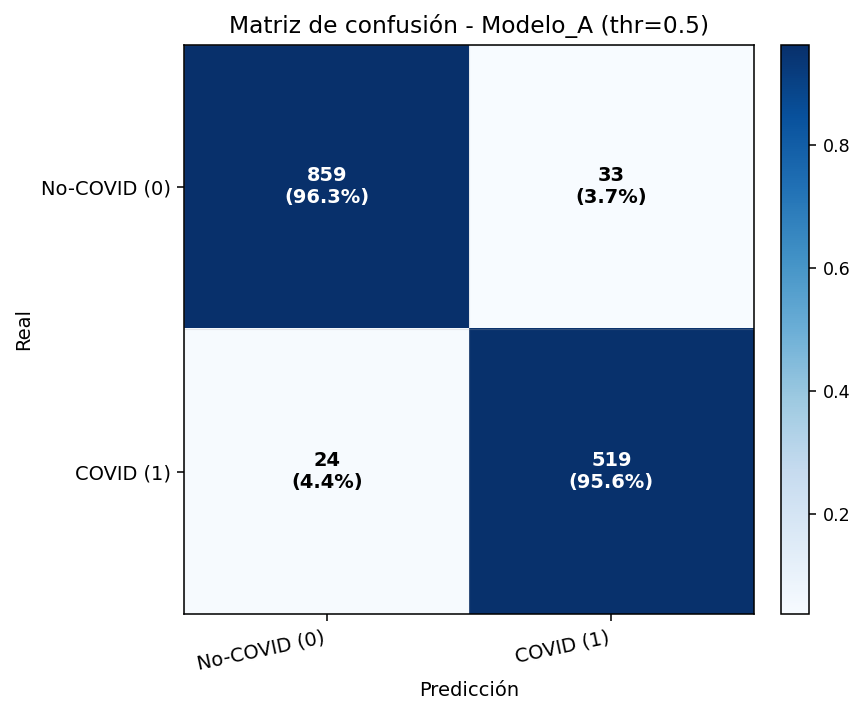

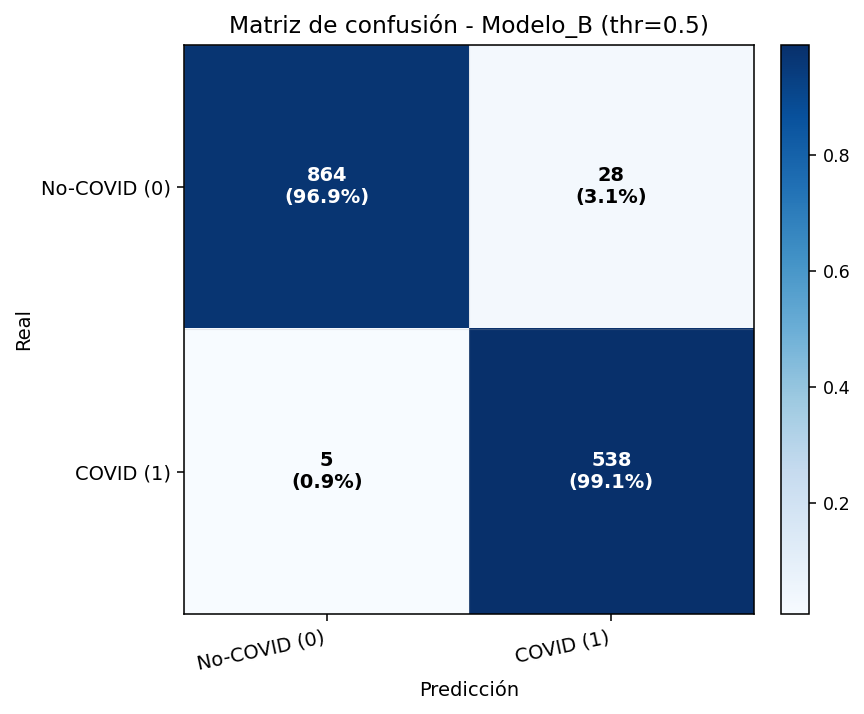

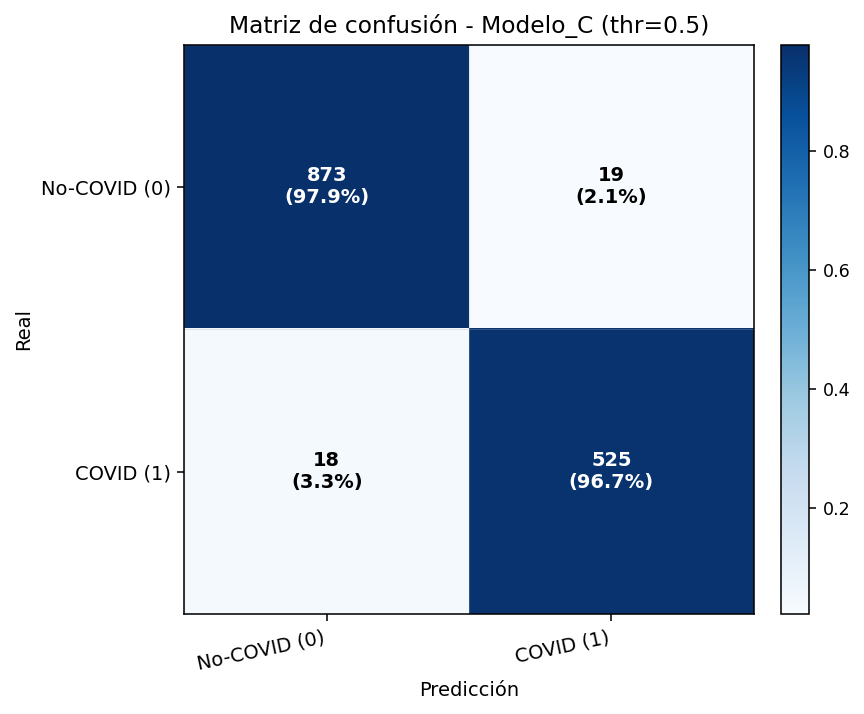

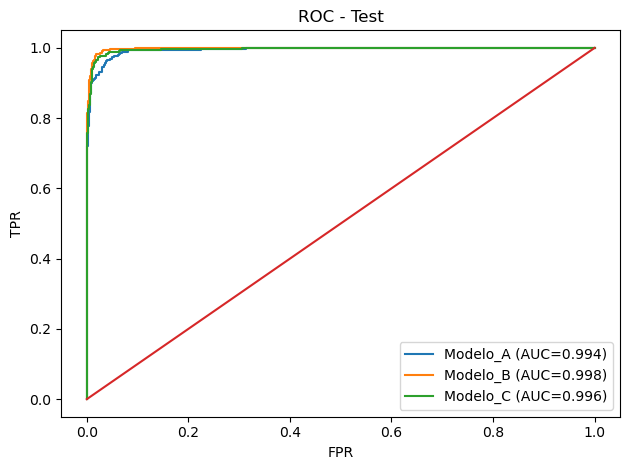

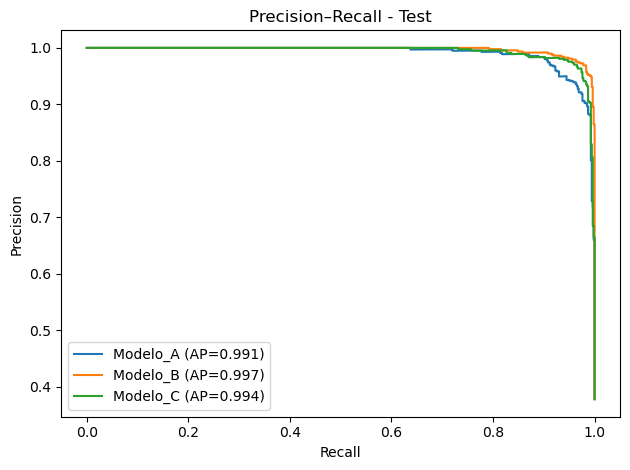

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)
import numpy as np
import pandas as pd
import torch
import os

CHECKPOINTS = {
    "Modelo_A": os.path.join(OUT_DIR, "runs", "Modelo_A_baseline", "best_hybrid_exp2.pt"),
    "Modelo_B": os.path.join(OUT_DIR, "runs", "Modelo_B_stable",   "best_hybrid_exp2.pt"),
    "Modelo_C": os.path.join(OUT_DIR, "runs", "Modelo_C_fast_lr",  "best_hybrid_exp2.pt"),
}

THRESH = 0.5

def extract_state_dict(ckpt):
    if isinstance(ckpt, dict):
        for k in ["state_dict", "model_state_dict", "model_state", "model"]:
            if k in ckpt and isinstance(ckpt[k], dict):
                sd = ckpt[k]
                break
        else:
            sd = ckpt
    else:
        sd = ckpt

    if isinstance(sd, dict):
        new_sd = {}
        for k, v in sd.items():
            nk = k.replace("module.", "") if k.startswith("module.") else k
            new_sd[nk] = v
        sd = new_sd
    return sd


# =========================
# Evaluación
# =========================
results = {}
PRED_CACHE = {}

for name, ckpt_path in CHECKPOINTS.items():
    print(f"\n=== Evaluando {name} ===")
    print("Checkpoint:", ckpt_path)

    model = build_model().to(DEVICE)
    model.eval()

    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    state_dict = extract_state_dict(ckpt)

    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    print("Missing keys:", len(missing), "| Unexpected keys:", len(unexpected))

    y_true, y_prob = [], []

    with torch.no_grad():
        for x, y, _ in test_loader:
            x = x.to(DEVICE)
            logits = model(x)
            prob = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_true.extend(y.numpy())
            y_prob.extend(prob)

    y_true = np.array(y_true).astype(int)
    y_prob = np.array(y_prob).astype(float)
    y_pred = (y_prob >= THRESH).astype(int)

    PRED_CACHE[name] = {"y_true": y_true, "y_prob": y_prob, "y_pred": y_pred}

    results[name] = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, y_prob),
    }

df_results = pd.DataFrame(results).T
print("\n=== Tabla de resultados (TEST) ===")
display(df_results)


# =========================
# MATRIZ DE CONFUSIÓN (PRO)
# =========================

labels = ["No-COVID (0)", "COVID (1)"]

def plot_confusion_matrix_pro(cm, class_names, title="", normalize=True):
    cm = np.array(cm, dtype=float)

    if normalize:
        cm_norm = cm / cm.sum(axis=1, keepdims=True)
        display_matrix = cm_norm
    else:
        display_matrix = cm

    fig, ax = plt.subplots(figsize=(6.2, 5.2), dpi=140)
    im = ax.imshow(display_matrix, cmap="Blues")

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicción",
        ylabel="Real",
        title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=12, ha="right")

    ax.set_xticks(np.arange(-.5, len(class_names), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(class_names), 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.6, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)

    for i in range(2):
        for j in range(2):
            count = int(cm[i, j])
            pct = display_matrix[i, j] * 100
            ax.text(
                j, i, f"{count}\n({pct:.1f}%)",
                ha="center", va="center",
                fontsize=10,
                fontweight="semibold",
                color="white" if display_matrix[i, j] > 0.6 else "black"
            )

    fig.tight_layout()
    plt.show()


for name, data in PRED_CACHE.items():
    cm = confusion_matrix(data["y_true"], data["y_pred"], labels=[0, 1])
    plot_confusion_matrix_pro(
        cm,
        class_names=labels,
        title=f"Matriz de confusión - {name} (thr={THRESH})",
        normalize=True
    )


# =========================
# ROC
# =========================
plt.figure()
for name, data in PRED_CACHE.items():
    fpr, tpr, _ = roc_curve(data["y_true"], data["y_prob"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC - Test")
plt.legend()
plt.tight_layout()
plt.show()


# =========================
# Precision–Recall
# =========================
plt.figure()
for name, data in PRED_CACHE.items():
    p, r, _ = precision_recall_curve(data["y_true"], data["y_prob"])
    ap = average_precision_score(data["y_true"], data["y_prob"])
    plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall - Test")
plt.legend()
plt.tight_layout()
plt.show()

